In [5]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
    
with open('/kaggle/input/vk-ds-cup/ranking_train.jsonl', 'r') as f:
    train_data = [json.loads(line) for line in f]

with open('/kaggle/input/vk-ds-cup/ranking_test.jsonl', 'r') as f:
    test_data = [json.loads(line) for line in f]
    
def data_prepare(data):

    df = pd.DataFrame(data)

    df = pd.concat([df[['text']], pd.json_normalize(df.comments)], axis=1)

    df = pd.melt(df, id_vars='text', value_vars=[0, 1, 2, 3, 4])

    df.sort_values(by=['text'], inplace=True)

    df = pd.concat([df[['text']], df[['value']].iloc[:,0].apply(pd.Series)], axis=1)

    df.columns = ['post', 'comment', 'score']

    df['post_id']=df.post.factorize()[0]
    
    return(df)

train_df = data_prepare(train_data)
test_df = data_prepare(test_data)
# Размер обучающей и тестовой выборок
print(f"Train samples: {len(train_df)}")
print(f"Test samples: {len(test_df)}")

# Общая информация по датафреймам
print(train_df.info())
print(test_df.info())

# Статистические характеристики данных
print(train_df.describe())

Train samples: 440535
Test samples: 70020
<class 'pandas.core.frame.DataFrame'>
Int64Index: 440535 entries, 132334 to 85159
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   post     440535 non-null  object
 1   comment  440535 non-null  object
 2   score    440535 non-null  int64 
 3   post_id  440535 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 16.8+ MB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 70020 entries, 13655 to 28165
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   post     70020 non-null  object
 1   comment  70020 non-null  object
 2   score    0 non-null      object
 3   post_id  70020 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 2.7+ MB
None
               score        post_id
count  440535.000000  440535.000000
mean        2.000000   43831.230924
std         1.414215   25308.204765
min         0.000000       

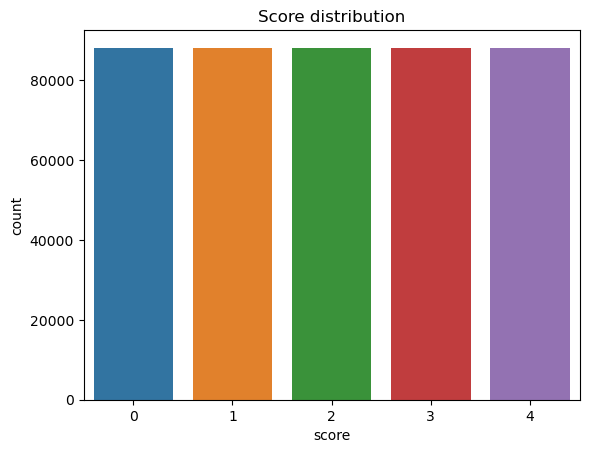

In [6]:
# Гистограмма распределения оценок комментариев
sns.countplot(x='score', data=train_df)
plt.title('Score distribution')
plt.show()

In [42]:
train_df

,post,comment,score,post_id
132334,"\t Mac OS X 10.8 restricted to App Store, sign...",From the article:&#62; When Apple first unveil...,1,0
396655,"\t Mac OS X 10.8 restricted to App Store, sign...",The title is incorrect: OS X 10.8 (Mountain Li...,4,0
220441,"\t Mac OS X 10.8 restricted to App Store, sign...",Appalling but I can't really fault them for re...,2,0
308548,"\t Mac OS X 10.8 restricted to App Store, sign...","What is it about the ""geek"" mindset that makes...",3,0
44227,"\t Mac OS X 10.8 restricted to App Store, sign...","The headline is fairly misleading, and the art...",0,0
...,...,...,...,...
437587,🌉,How did you find that?EDIT: if I wasn&#x27;t u...,4,87663
349480,🌉,"Anyone can make a redirect to anything, genera...",3,87663
173266,🌉,Looks like a number of emoji will redirect you...,1,87663
261373,🌉,Why are emoji&#x27;s being used in URL&#x27;s ...,2,87663


In [8]:
%%capture installation.log
import os
def install_java():
  !apt-get install -y openjdk-8-jdk-headless -qq > /dev/null
  os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
  !java -version
%env LC_ALL=C.UTF-8
%env LANG=C.UTF-8
install_java()
!pip install spacy
!pip install language_tool_python
!python -m spacy download en_core_web_sm
!pip install transformers
!pip install tqdm
!pip install psutil
!pip install Cython
!pip install tensorflow-hub
!pip install memory_profiler


In [11]:
import psutil
# Возвращает количество ядер
max_workers = psutil.cpu_count(logical=True)
print(max_workers)

# Возвращает объект, содержащий информацию о памяти
memory = psutil.virtual_memory()

# Выводит доступную память в байтах
print(memory.available)

4
31040864256


In [10]:
%%capture analyze_comments.log
import re
import csv
import torch
import string
import numpy as np
import spacy
import tensorflow as tf
import tensorflow_hub as hub
import nltk
import multiprocessing as mp
import language_tool_python
import concurrent.futures as futures
from memory_profiler import profile
from string import punctuation
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
from textblob import TextBlob
from numba import jit
from concurrent.futures import ProcessPoolExecutor, as_completed
from functools import partial
from tqdm import tqdm
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from transformers import AutoModelForSequenceClassification, AutoModel, AutoTokenizer, TextClassificationPipeline
from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import rankdata

In [12]:
# Load pre-trained models
stop_words = set(stopwords.words('english')) 
# nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
# use = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")
# sia = SentimentIntensityAnalyzer()
# tool = language_tool_python.LanguageTool('en-US')

# # Initialize tokenizer and pipeline
# model_path = "martin-ha/toxic-comment-model"
# tokenizer = AutoTokenizer.from_pretrained(model_path)
# model = AutoModelForSequenceClassification.from_pretrained(model_path)
# pipeline = TextClassificationPipeline(model=model, tokenizer=tokenizer)
# tokenizer_d = AutoTokenizer.from_pretrained('distilbert-base-multilingual-cased')
# model_d = AutoModel.from_pretrained('distilbert-base-multilingual-cased')

In [ ]:

# def get_polarity(text):
#     try:
#         textblob = TextBlob(text)
#         pol = textblob.sentiment.polarity
#     except:
#         pol = 0.0
#     return pol

# def get_subjectivity(text):
#     try:
#         textblob = TextBlob(text)
#         subj = textblob.sentiment.subjectivity
#     except:
#         subj = 0.0
#     return subj

In [13]:
# def evaluate_toxicity(comment, max_length=512, stride=256):

#     # Split comment into smaller segments
#     segments = []
#     if len(comment) > max_length:
#         # Split comment into overlapping segments
#         for i in range(0, len(comment), stride):
#             segment = comment[i:i+max_length]
#             # Force segment to be exactly 512 characters
#             segment = segment[:512]
#             segments.append(segment)
#     else:
#         segments.append(comment)

#     # Calculate toxicity score for each segment
#     toxicity_scores = []
#     for segment in segments:
#         input_ids = tokenizer.encode(segment, truncation=True, padding=True, return_tensors='pt')
#         tokens = tokenizer.convert_ids_to_tokens(input_ids[0])
#         text = tokenizer.convert_tokens_to_string(tokens)
#         output = pipeline(text)
#         toxicity_scores.append(output[0]['score'])
    
#     # Average toxicity scores across segments
#     toxicity_score = np.mean(toxicity_scores)

#     return toxicity_score

# def compute_use_vectors(text, model, tokenizer, max_length=512, stride=256):
#     # Split input sequence into smaller segments
#     segments = []
#     if len(text) > max_length:
#         # Split text into overlapping segments
#         for i in range(0, len(text), stride):
#             segment = text[i:i+max_length]
#             # Force segment to be exactly 512 characters
#             segment = segment[:512]
#             segments.append(segment)
#     else:
#         segments.append(text)

#     # Compute embeddings for each segment
#     batch_size = 8
#     embeddings = []
#     for i in range(0, len(segments), batch_size):
#         batch_segments = segments[i:i+batch_size]
#         batch_input = tokenizer.batch_encode_plus(batch_segments, padding = True, truncation=True, return_tensors='pt')
#         batch_embeddings = model(batch_input['input_ids'], batch_input['attention_mask'])
#         last_hidden_state_tensor = batch_embeddings.last_hidden_state
#         embeddings.append(last_hidden_state_tensor.detach().cpu().numpy())


#     # Concatenate embeddings to obtain full vector representation, even if embeddings is empty
#     if len(embeddings) > 0:
#         embeddings = np.concatenate(embeddings, axis=0)
#     else:
#         embeddings = np.array([])

#     return torch.tensor(np.stack(embeddings))

# # functions to get polatiy and subjectivity of text using the module textblob
# def get_polarity(text):
#     try:
#         textblob = TextBlob(unicode(text, 'utf-8'))
#         pol = textblob.sentiment.polarity
#     except:
#         pol = 0.0
#     return pol

# def get_subjectivity(text):
#     try:
#         textblob = TextBlob(unicode(text, 'utf-8'))
#         subj = textblob.sentiment.subjectivity
#     except:
#         subj = 0.0
#     return subj

def analyze_comment(comment, post_text, score):
    # Find number of words
    words = comment.split()
    num_words = len(words)
    
    # Find number of unique words
    unique_words = set(words)
    num_unique_words = len(unique_words)
    
    # Find number of letters and punctuation marks
    num_letters = sum([len(word) for word in words])
    num_punctuation = sum([1 for char in comment if char in string.punctuation])
    
    # Find number of uppercase letters and words
    num_uppercase_letters = sum([1 for char in comment if char.isupper()])
    num_uppercase_words = sum([1 for word in words if word.isupper()])
    
    # Find number of stop words
    num_stop_words = sum([1 for word in comment.lower().split() if word in stop_words])
    
    # Find average word length
    if num_words > 0:
        avg_word_length = num_letters / num_words
    else:
        avg_word_length = 0
    
    # Find number of sentences
    # sentences = list(nlp(comment).sents)
    # num_sentences = len(sentences)
#     num_sentences = sum(1 for _ in nlp()(comment).sents)
    
#     # Calculate sentiment score
#     sentiment_score = sia.polarity_scores(comment)['compound']
    
    # Compute embeddings for post and comment
#     post_embedding = compute_use_vectors(post_text, model = model_d, tokenizer = tokenizer_d)[0]
#     comment_embedding = compute_use_vectors(comment, model = model_d, tokenizer = tokenizer_d)[0]
    
    # # pad the shorter vector with zeros
    # if comment_embedding.shape[1] > post_embedding.shape[1]:
    #     pad_width = ((0, 0), (0, comment_embedding.shape[1]-post_embedding.shape[1]))
    #     post_embedding = np.pad(post_embedding, pad_width, mode='constant')
    # else:
    #     pad_width = ((0, 0), (0, post_embedding.shape[1]-comment_embedding.shape[1]))
    #     comment_embedding = np.pad(comment_embedding, pad_width, mode='constant')

    # # compute cosine similarity
    # similarity_score = cosine_similarity(comment_embedding, post_embedding)[0][0]

#     # Calculate toxicity score
#     # print(type(comment))
#     toxicity_score = evaluate_toxicity(comment, max_length=512, stride=256)
    
    return (post_text,
            comment,
            score,
            num_words,
            num_unique_words,
            avg_word_length,
            num_punctuation,
            num_uppercase_letters,
            num_uppercase_words,
            num_stop_words
#             num_sentences,
#             sum(c.isdigit() for c in comment),
#             comment.count("http"),
#             comment.count("#"),
#             sum(not c.isalnum() and c not in string.whitespace for c in comment),
#             sum(1 for word in comment.split() if word.isupper() and len(word) >= 2),
#             len(tool.check(comment)),
#             comment.lower().count('Edit'), 
#             sum([1 for word in comment.split() if not word.isascii()]), 
#             num_punctuation / len(comment), 
#             len([ent for ent in nlp(comment).ents if ent.label_ in ['PERSON', 'ORG', 'GPE']]), 
#             sentiment_score 
            # similarity_score, 
#             toxicity_score)
           )


# def print_feature_statistics(result):
#     feature_names = list(result.keys())
#     feature_frequencies = [len(result[name]) for name in feature_names]
#     feature_ranks = rankdata(feature_frequencies, method='dense')
#     feature_rank_dict = {name: rank for name, rank in zip(feature_names, feature_ranks)}

#     # Sort features by their ranks
#     sorted_features = sorted(feature_rank_dict.items(), key=lambda x: x[1])

#     # Print results
#     for feature, rank in sorted_features:
#         values = result[feature]
#         if isinstance(values[0], np.ndarray):
#             values = [list(v) for v in values]
#         print(f"{feature} (rank {rank}):")
#         print(f"\tMin: {np.min(values)}")
#         print(f"\tMax: {np.max(values)}")
#         print(f"\tMean: {np.mean(values)}")
#         print(f"\tMedian: {np.median(values)}")
#         print(f"\tStd: {np.std(values)}")
#         print("")
        
# def convert_to_csv(result, filename):
#     feature_names = list(result.keys())
#     feature_frequencies = [len(result[name]) for name in feature_names]
#     feature_ranks = rankdata(feature_frequencies, method='dense')
#     feature_rank_dict = {name: rank for name, rank in zip(feature_names, feature_ranks)}

#     # Sort features by their ranks
#     sorted_features = sorted(feature_rank_dict.items(), key=lambda x: x[1])

#     with open(filename, 'w', newline='') as file:
#         writer = csv.writer(file)
#         writer.writerow(['Feature', 'Rank', 'Min', 'Max', 'Mean', 'Median', 'Std'])
#         for feature, rank in sorted_features:
#             values = result[feature]
#             if isinstance(values[0], np.ndarray):
#                 values = [list(v) for v in values]
#             writer.writerow([feature, rank, np.min(values), np.max(values), np.mean(values), np.median(values), np.std(values)])

In [22]:

def analyze_comments(df, max_workers, chunk_size=1000):

# Create a preallocated NumPy array to store results
    results = np.empty((len(df), 10), dtype=object)
    
    # Analyze comments in parallel
    with futures.ProcessPoolExecutor(max_workers=max_workers) as executor:
        futures_list = []
        i = 0
        for chunk_df in tqdm(np.array_split(df, len(df) // chunk_size + 1), total=len(df) // chunk_size + 1):
            for row in chunk_df.itertuples():
                comment = row.comment
                post_text = row.post
                score = row.score

                # Submit job to executor
                future = executor.submit(analyze_comment, comment, post_text, score)
                futures_list.append(future)
                i += 1
                if i % chunk_size == 0:
                    # Wait for all jobs in the current chunk to complete
                    results_list = []
                    for future in futures.as_completed(futures_list):
                        try:
                            result = future.result()
                            results_list.append(result)
                        except Exception as e:
                            print(f"Error occurred while processing task: {e}")
                    results[i-chunk_size:i] = np.vstack(results_list)
                    futures_list.clear()
        print("First loop successfully.")
        if futures_list:
            # Wait for all remaining jobs to complete
            results_list = []
            for future in tqdm(futures.as_completed(futures_list), total=len(futures_list)):
                try:
                    result = future.result()
                    results_list.append(result)
                except Exception as e:
                    print(f"Error occurred while processing task: {e}")
            results[i-len(futures_list):i] = np.vstack(results_list)

    print("Analysis completed successfully.") 

    # Convert results to a pandas DataFrame
    result_df = pd.DataFrame(results, columns=['text', 'comment', 'score', 
                                                'num_words', 'num_unique_words', 'avg_word_length',
                                                'num_punctuation', 'num_uppercase_letters', 'num_uppercase_words',
                                                'num_stop_words'])

    return result_df

In [23]:
train_df_analyzed = analyze_comments(train_df,max_workers)
train_df_analyzed

100%|██████████| 441/441 [03:26<00:00,  2.14it/s]


First loop successfully.


100%|██████████| 535/535 [00:00<00:00, 3583.14it/s]


Analysis completed successfully.


,text,comment,score,num_words,num_unique_words,avg_word_length,num_punctuation,num_uppercase_letters,num_uppercase_words,num_stop_words
0,"\t Mac OS X 10.8 restricted to App Store, sign...",From the article:&#62; When Apple first unveil...,1,159,113,4.622641509433962,29,12,0,77
1,"\t Mac OS X 10.8 restricted to App Store, sign...",The title is incorrect: OS X 10.8 (Mountain Li...,4,47,42,4.404255319148936,10,11,2,20
2,"\t Mac OS X 10.8 restricted to App Store, sign...",Appalling but I can't really fault them for re...,2,112,87,4.9375,17,8,1,45
3,"\t Mac OS X 10.8 restricted to App Store, sign...","The headline is fairly misleading, and the art...",0,173,134,5.196531791907514,27,26,0,77
4,\tAsk HN: Questions to ask candidates in a job...,If you've never interviewed someone before you...,3,37,33,6.54054054054054,16,9,2,14
...,...,...,...,...,...,...,...,...,...,...
440530,🌉,How did you find that?EDIT: if I wasn&#x27;t u...,4,25,23,4.64,15,11,4,12
440531,🌉,Looks like a number of emoji will redirect you...,1,14,14,19.071428571428573,61,18,0,6
440532,🌉,"Anyone can make a redirect to anything, genera...",3,41,39,13.487804878048781,109,27,0,17
440533,🌉,"For anyone that is seeing the square block, if...",0,46,36,4.5,10,3,0,22
